[go here](#here)

# [NSF's OIR Lab](https://nationalastro.org/) Astro Archive: Advanced Search

[Community Science and Data Center](https://nationalastro.org/programs/csdc/)

## Table Of Contents:
* [Goals & notebook summary](#goals)
* [Summary of this API (list of web services)](#summary)
* [Imports and setup](#init)
* [Details](#details); Example of every service. Special cases. Error Handling
* [Documentation](#doc)
* [Glossary](#glos)

<a class="anchor" id="goals"></a>
# Goals
Instructions and examples for using Advanced Search API for accessing OIRLab Archive metadata.

# Notebook Summary
We show you how to use the API to search the Archive for FITS files by **any** field in the FITS headers.

#### Add "about the current archive"; give various stats (number of files, hdus in archive; period of time covered; most recently added; list of telescopes/insruments!!!

 ## Summary of this API (list of web services) <a id="summary">
For full list, see: [http://marsnat2.pat.dm.noao.edu:8000/api-docs/#/api](http://marsnat2.pat.dm.noao.edu:8000/api-docs/#/api)

1. [GET] /api/natica/retrieve/{md5}/
   Construct and Retrieve one FITS file from the Archive containing only
1. [GET] /api/sia/vohdu
   Get HDUs matching cone query.
1. [GET] /api/sia/vohdu{format}
   Get HDUs matching cone query.
1. [GET] /api/sia/voimg
   Get FITS Images matching cone/rectangle query.
1. [GET] /api/sia/voimg{format}
   Get FITS Images matching cone/rectangle query.


## Imports and setup <a id="init">
Some of these imports are just for presentation in the juypter notebook.  You may not need it all.

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import astropy.io.fits as pyfits
import astropy.utils as autils
import requests
import json
from pprint import pprint as pp

print(f'Using Python version: {sys.version}')

Using Python version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [2]:
%run utils.ipynb
tic()

baseurl=f'{natroot}/api/sia'
print(f'This notebook demonstrates services rooted at {baseurl}')

This notebook demonstrates services rooted at https://marsnat1.stage.dm.noao.edu/api/sia


## Details <a id="details">

* [Allowed query string Parameters](#METADATA)
* [Simple query against HDUs by Location](#vohdu)
* [Get File](#retrieve) (authenticate for non-public files)

* [Additional Documentation](#doc)

### Get Parameters allowed in query string for VOHDU service. <a id="METADATA" />

In [3]:
# Params allowed? JSON format (also: csv, xml, votable[default], json)
pd.read_json(json.dumps(requests.get(f'{baseurl}/vohdu?FORMAT=METADATA&format=json').json()))

,DataType,DefaultValue,Doc,ParameterName
0,char,NA,NA,INPUT:DATE
1,char,NA,NA,INPUT:FILENAME
2,char,text/html,Type of content,INPUT:FORMAT
3,char,ALL,Telescope used to collect raw image. one-of:['...,INPUT:telescope
4,char,ALL,Instrument used to collect raw image. one-of:[...,INPUT:instrument
5,char,ALL,"Processing Type. one-of:['instcal', 'masterca...",INPUT:proctype
6,char,ALL,"Product Type. one-of:['dqmask', 'expmap', 'gr...",INPUT:prodtype
7,char,ALL,Date of observation,INPUT:caldat
8,char,"0.0,0.0","The position of the region of interest, expres...",INPUT:POS
9,double,0.05,Angular size of ROI given in decimal degrees,INPUT:SIZE


## Simple query against HDUs by location (vohdu) <a id="vohdu" />

In [4]:
sia_df = pd.read_json(json.dumps(requests.get(f'{baseurl}/vohdu?POS={ra},{dec}&SIZE={size}&limit=3&format=json').json()))
sia_df

,archive_filename,caldat,date_obs,dec,hdu_idx,instrument,md5sum,proc_type,prod_type,ra,telescope
0,string,string,string,float,int,string,string,string,string,float,string
1,/net/archive/pipe/20170602/ct4m/2017A-0260/c4d...,2017-06-02,2017-06-03,-32.0097,17,decam,f3b293a223ca8a862cdf4862629136aa,instcal,image,359.888,ct4m
2,/net/archive/pipe/20170602/ct4m/2017A-0260/c4d...,2017-06-02,2017-06-03,-32.0097,17,decam,7d4209bd5f0fc0a1a351f92436520c76,resampled,image,359.888,ct4m
3,/net/archive/pipe/20170602/ct4m/2017A-0260/c4d...,2017-06-02,2017-06-03,-32.0097,17,decam,f0222309429aafe8cb8c701942fc9af3,skysub,image,359.888,ct4m
4,/net/archive/pipe/20170602/ct4m/2017A-0260/c4d...,2017-06-02,2017-06-03,-32.0097,17,decam,4c7f9a5f4ff618f0e20549871a71bf48,instcal,wtmap,359.888,ct4m
5,/net/archive/pipe/20170602/ct4m/2017A-0260/c4d...,2017-06-02,2017-06-03,-32.0097,17,decam,3561c7893a68e709ffae74d857a49865,instcal,dqmask,359.888,ct4m
6,/net/archive/pipe/20170105/ct4m/2016B-0124/c4d...,2017-01-05,2017-01-06,-32.0123,16,decam,930e54296d135ab660042d922967e118,resampled,dqmask,359.889,ct4m
7,/net/archive/pipe/20170105/ct4m/2016B-0124/c4d...,2017-01-05,2017-01-06,-32.0123,16,decam,d69f77d903919cc612a50c951622deca,resampled,image,359.889,ct4m
8,/net/archive/pipe/20170105/ct4m/2016B-0124/c4d...,2017-01-05,2017-01-06,-32.0123,16,decam,59bead658458a566c3d5bca6943e18e7,instcal,wtmap,359.889,ct4m
9,/net/archive/pipe/20170105/ct4m/2016B-0124/c4d...,2017-01-05,2017-01-06,-32.0123,16,decam,3de698c389e972d43bdc1e7b2cb73154,instcal,image,359.889,ct4m


## Get FITS file containing single HDU and display it<a id="retrieve" />

In [5]:
selectedRow=3
print(f'selectedRow={selectedRow}')
fileid = sia_df['md5sum'][selectedRow]
hduidx = sia_df['hdu_idx'][selectedRow]
print(fileid,hduidx)

selectedRow=3
f0222309429aafe8cb8c701942fc9af3 17


In [6]:
onehduurl = f'{natroot}/api/natica/retrieve/{fileid}/?hdus={hduidx}'
onehduurl

'https://marsnat1.stage.dm.noao.edu/api/natica/retrieve/f0222309429aafe8cb8c701942fc9af3/?hdus=17'

(4094, 2046)

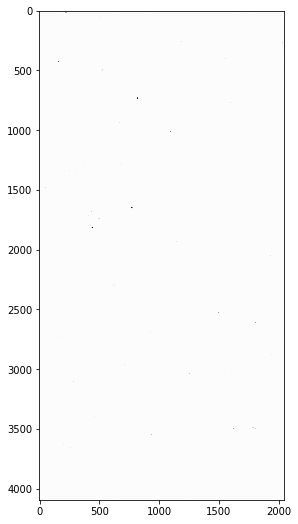

In [7]:
zimage = pyfits.getdata(autils.data.download_file(onehduurl,cache=True,show_progress=False,timeout=120))
plt.rcParams["figure.figsize"] = [16,9]
plt.imshow(zimage,cmap=matplotlib.cm.gray_r)
zimage.shape

### Zoom in [yStart:yEnd, xStart:xEnd]

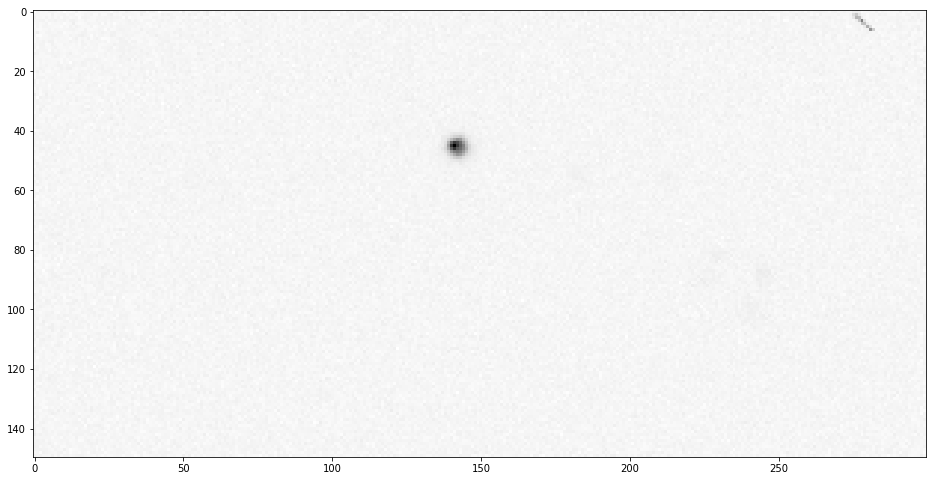

In [8]:
plt.imshow(zimage[1100:1250, 600:900],cmap=matplotlib.cm.gray_r)

# HERE !!! <a id="here">

## Error Conditions <a id="errors" />
- Unknown query string params are ignored
- non-float SIZE

### Parameter error: Negative size given

In [9]:
#url=f'{baseurl}/vohdu?POS={ra},{dec}&SIZE=-1.0&limit=3&format=json'
#print(f'url={url}')
#requests.get(url).json()

apiurl=f'{baseurl}/vohdu?POS={ra},{dec}&SIZE=-1.0&limit=3&format=json'
response = requests.get(apiurl)
if response.status_code == 200:
    pp(response.content)
else:
    print(response.json()['errorMessage'])
    #print(response.json()['traceback'])  # for API developer use


Unexpected Error: range lower bound must be less than or equal to range upper bound
LINE 1: ...M "natica_hdu" WHERE ("natica_hdu"."dec_range" && '[ -31.0, ...
                                                             ^



In [10]:
import datetime
elapsed = toc()
print(f'Elapsed seconds={elapsed}')
str(datetime.datetime.now())

Elapsed seconds=13.939819225110114


'2020-01-28 12:55:49.788815'

# Resources and references <a id="doc" />

[Simple Image Access Specification](http://www.ivoa.net/documents/latest/SIA.html) Version 1.0; IVOA Proposed Recommendation 21 Mai 2009

[dal API](http://marsnat2.pat.dm.noao.edu:8000/api-docs/#/dal)
We should look at fancy annotation to make this better. Programmers will want clear doc of what parameters can be passed to each service.

[Data  Models](https://marsnat2.pat.dm.noao.edu:8000/admin/doc/models/)

# Glossary <a id="glos">
    
Term     | Definition
---------|---------------------------------------------------------------------------------------------
ProcType | Processing Type; pipeline process used to generate reduced FITS from raw FITS